In [1]:
import tensorflow as tf
import os

sess = tf.Session()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device



In [2]:
%matplotlib inline

import gym
from gym.wrappers import Monitor
import itertools
import numpy as np
import os
import random
import sys
import psutil
import tensorflow as tf

if "../" not in sys.path:
    sys.path.append("../")

from lib import plotting
from collections import deque, namedtuple


In [3]:
# env = gym.envs.make("Breakout-v0")
env = gym.envs.make("MsPacman-v0")

# Atari Actions: 0 (noop), 1 (fire), 2 (left) and 3 (right) are valid actions
# VALID_ACTIONS = [0, 1, 2, 3]
VALID_ACTIONS = [0, 2, 3, 4, 5]

In [4]:

# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P
from matplotlib import pyplot as plt
import pickle
import os
import cv2
slim=tf.contrib.slim

# if not os.path.exists('models/research/slim'):
#   !git clone https://github.com/tensorflow/models/
# old_cwd = os.getcwd()
# os.chdir('models/research/slim')
# from nets import inception_v3
# os.chdir(old_cwd)

# From our repository.
import saliency

%matplotlib inline

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
#     im = ((im + 1) * 127.5).astype(np.uint8)
    P.imshow(im)
    P.title(title)
#     plt.figure()
#     plt.imshow(im)


def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.gray)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def ShowFilteredImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    
    # Applying threshold
    im = im*(im>0.6)*1.5

    # Gaussing blurring
    im = cv2.GaussianBlur(im,(3,3),5)

    # Show the image
    P.imshow(im, cmap=P.cm.coolwarm, vmin=0, vmax=1)

#     P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)
    
def ShowDivergingImage(grad, title='', percentile=99, ax=None):
    if ax is None:
        fig, ax = P.subplots()
    else:
        fig = ax.figure

    P.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grad, cmap=P.cm.coolwarm, vmin=-1, vmax=1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    P.title(title)    
    
def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    print("load: ", im.shape)
    return im


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
class StateProcessor():
    """
    Processes a raw Atari images. Resizes it and converts it to grayscale.
    """
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            # self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(
                self.output, [160, 160], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)

    def process(self, sess, state):
        """
        Args:
            sess: A Tensorflow session object
            state: A [210, 160, 3] Atari RGB State

        Returns:
            A processed [84, 84] state representing grayscale values.
        """
        return sess.run(self.output, { self.input_state: state })

In [6]:
class Estimator():
    """Q-Value Estimator neural network.

    This network is used for both the Q-Network and the Target Network.
    """

    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)

    def _build_model(self):
        """
        Builds the Tensorflow graph.
        """

        # Placeholders for our input
        # Our input are 4 grayscale frames of shape 84, 84 each
        # self.X_pl = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="X")
        self.X_pl = tf.placeholder(shape=[None, 160, 160, 4], dtype=tf.uint8, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

        self.X = tf.to_float(self.X_pl) / 255.0
        batch_size = tf.shape(self.X_pl)[0]

        # Three convolutional layers
        conv1 = tf.contrib.layers.conv2d(
            self.X, 32, 8, 4, activation_fn=tf.nn.relu)
        conv2 = tf.contrib.layers.conv2d(
            conv1, 64, 4, 2, activation_fn=tf.nn.relu)
        conv3 = tf.contrib.layers.conv2d(
            conv2, 64, 3, 1, activation_fn=tf.nn.relu)

        
        # Fully connected layers
        flattened = tf.contrib.layers.flatten(conv3)
        fc1 = tf.contrib.layers.fully_connected(flattened, 512)
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(VALID_ACTIONS))

        
#         self.input_X = X
        print("gradients:", tf.gradients(self.predictions, self.X))
        
        
        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)

        # Calculate the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)

        # Optimizer Parameters from original paper
        self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())

        # Summaries for Tensorboard
        self.summaries = tf.summary.merge([
            tf.summary.scalar("loss", self.loss),
            tf.summary.histogram("loss_hist", self.losses),
            tf.summary.histogram("q_values_hist", self.predictions),
            tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
        ])

    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, 4, 84, 84, 1]

        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated 
          action values.
        """
        return sess.run(self.predictions, { self.X_pl: s })

    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, 4, 84, 84, 1]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return loss

In [7]:
# For Testing....

tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)

e = Estimator(scope="test")
sp = StateProcessor()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
gradients: [<tf.Tensor 'test/gradients/test/Conv/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 160, 160, 4) dtype=float32>]
Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:


# Example observation batch
observation = env.reset()

observation_p = sp.process(sess, observation)
observation = np.stack([observation_p] * 4, axis=2)
observations = np.array([observation] * 2)

# Test Prediction
print(e.predict(sess, observations))

# Test training step
y = np.array([10.0, 10.0])
a = np.array([1, 3])


[[0.         0.1017128  0.04946569 0.         0.07455963]
 [0.         0.1017128  0.04946569 0.         0.07455963]]


In [12]:
class ModelParametersCopier():
    """
    Copy model parameters of one estimator to another.
    """
    
    def __init__(self, estimator1, estimator2):
        """
        Defines copy-work operation graph.  
        Args:
          estimator1: Estimator to copy the paramters from
          estimator2: Estimator to copy the parameters to
        """
        e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
        e1_params = sorted(e1_params, key=lambda v: v.name)
        e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
        e2_params = sorted(e2_params, key=lambda v: v.name)

        self.update_ops = []
        for e1_v, e2_v in zip(e1_params, e2_params):
            op = e2_v.assign(e1_v)
            self.update_ops.append(op)
            
    def make(self, sess):
        """
        Makes copy.
        Args:
            sess: Tensorflow session instance
        """
        sess.run(self.update_ops)

In [13]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [14]:
def deep_q_learning(sess,
                    env,
                    q_estimator,
                    target_estimator,
                    state_processor,
                    num_episodes,
                    experiment_dir,
                    replay_memory_size=500000,
                    replay_memory_init_size=50000,
                    update_target_estimator_every=10000,
                    discount_factor=0.99,
                    epsilon_start=1.0,
                    epsilon_end=0.1,
                    epsilon_decay_steps=500000,
                    batch_size=32,
                    record_video_every=50):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.

    Args:
        sess: Tensorflow Session object
        env: OpenAI environment
        q_estimator: Estimator object used for the q values
        target_estimator: Estimator object used for the targets
        state_processor: A StateProcessor object
        num_episodes: Number of episodes to run for
        experiment_dir: Directory to save Tensorflow summaries in
        replay_memory_size: Size of the replay memory
        replay_memory_init_size: Number of random experiences to sampel when initializing 
          the reply memory.
        update_target_estimator_every: Copy parameters from the Q estimator to the 
          target estimator every N steps
        discount_factor: Gamma discount factor
        epsilon_start: Chance to sample a random action when taking an action.
          Epsilon is decayed over time and this is the start value
        epsilon_end: The final minimum value of epsilon after decaying is done
        epsilon_decay_steps: Number of steps to decay epsilon over
        batch_size: Size of batches to sample from the replay memory
        record_video_every: Record a video every N episodes

    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

    # The replay memory
    replay_memory = []
    
    # Make model copier object
    estimator_copy = ModelParametersCopier(q_estimator, target_estimator)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    # For 'system/' summaries, usefull to check if currrent process looks healthy
    current_process = psutil.Process()

    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    monitor_path = os.path.join(experiment_dir, "monitor")
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(monitor_path):
        os.makedirs(monitor_path)

    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
    
    # Get the current time step
    total_t = sess.run(tf.contrib.framework.get_global_step())

    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

    # The policy we're following
    policy = make_epsilon_greedy_policy(
        q_estimator,
        len(VALID_ACTIONS))

    # Populate the replay memory with initial experience
    print("Populating replay memory...")
    state = env.reset()
    state = state_processor.process(sess, state)
    state = np.stack([state] * 4, axis=2)
    for i in range(replay_memory_init_size):
        action_probs = policy(sess, state, epsilons[min(total_t, epsilon_decay_steps-1)])
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
        next_state = state_processor.process(sess, next_state)
        next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
        replay_memory.append(Transition(state, action, reward, next_state, done))
        if done:
            state = env.reset()
            state = state_processor.process(sess, state)
            state = np.stack([state] * 4, axis=2)
        else:
            state = next_state


    # Record videos
    # Add env Monitor wrapper
    env = Monitor(env, directory=monitor_path, video_callable=lambda count: count % record_video_every == 0, resume=True)

    for i_episode in range(num_episodes):

        # Save the current checkpoint
        saver.save(tf.get_default_session(), checkpoint_path)

        # Reset the environment
        state = env.reset()
        state = state_processor.process(sess, state)
        state = np.stack([state] * 4, axis=2)
        loss = None

        # One step in the environment
        for t in itertools.count():

            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]

            # Maybe update the target estimator
            if total_t % update_target_estimator_every == 0:
                estimator_copy.make(sess)
                print("\nCopied model parameters to target network.")

            # Print out which step we're on, useful for debugging.
            print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                    t, total_t, i_episode + 1, num_episodes, loss), end="")
            sys.stdout.flush()

            # Take a step
            action_probs = policy(sess, state, epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
            next_state = state_processor.process(sess, next_state)
            next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)

            # If our replay memory is full, pop the first element
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)

            # Save transition to replay memory
            replay_memory.append(Transition(state, action, reward, next_state, done))   

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # Sample a minibatch from the replay memory
            samples = random.sample(replay_memory, batch_size)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))

            # Calculate q values and targets
            q_values_next = target_estimator.predict(sess, next_states_batch)
            targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * discount_factor * np.amax(q_values_next, axis=1)

            # Perform gradient descent update
            states_batch = np.array(states_batch)
            loss = q_estimator.update(sess, states_batch, action_batch, targets_batch)

            if done:
                break

            state = next_state
            total_t += 1

        # Add summaries to tensorboard
        episode_summary = tf.Summary()
        episode_summary.value.add(simple_value=epsilon, tag="episode/epsilon")
        episode_summary.value.add(simple_value=stats.episode_rewards[i_episode], tag="episode/reward")
        episode_summary.value.add(simple_value=stats.episode_lengths[i_episode], tag="episode/length")
        episode_summary.value.add(simple_value=current_process.cpu_percent(), tag="system/cpu_usage_percent")
        episode_summary.value.add(simple_value=current_process.memory_percent(memtype="vms"), tag="system/v_memeory_usage_percent")
        q_estimator.summary_writer.add_summary(episode_summary, i_episode)
        q_estimator.summary_writer.flush()
        
        yield total_t, plotting.EpisodeStats(
            episode_lengths=stats.episode_lengths[:i_episode+1],
            episode_rewards=stats.episode_rewards[:i_episode+1])

    self.replay_memory = replay_memory
    return stats

In [ ]:
tf.reset_default_graph()

# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("./experiments/{}".format(env.spec.id))

# Create a glboal step variable
global_step = tf.Variable(0, name='global_step', trainable=False)
    
# Create estimators
q_estimator = Estimator(scope="q_estimator", summaries_dir=experiment_dir)
target_estimator = Estimator(scope="target_q")

# State processor
state_processor = StateProcessor()

# Run it!
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for t, stats in deep_q_learning(sess,
                                    env,
                                    q_estimator=q_estimator,
                                    target_estimator=target_estimator,
                                    state_processor=state_processor,
                                    experiment_dir=experiment_dir,
                                    num_episodes=10000,
                                    replay_memory_size=50000,
                                    replay_memory_init_size=5000,
                                    update_target_estimator_every=10000,
                                    epsilon_start=1.0,
                                    epsilon_end=0.1,
                                    epsilon_decay_steps=500000,
                                    discount_factor=0.99,
                                    batch_size=32):

        print("\nEpisode Reward: {}".format(stats.episode_rewards[-1]))

gradients: [<tf.Tensor 'q_estimator/gradients/q_estimator/Conv/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 160, 160, 4) dtype=float32>]
gradients: [<tf.Tensor 'target_q/gradients/target_q/Conv/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 160, 160, 4) dtype=float32>]
Populating replay memory...

Copied model parameters to target network.
Step 351 (351) @ Episode 1/10000, loss: 0.10632599145174026

## Visualization below

### Gradient Saliency

(2, 160, 160, 4)
(2, 160, 160, 4)
[[0.08088367 0.         0.00235145 0.        ]
 [0.08088367 0.         0.00235145 0.        ]]
Tensor("strided_slice_10:0", shape=(4,), dtype=float32)
prediction_class:  0
y_qq 20.625349
gradients: [<tf.Tensor 'gradients_6/target_q/Conv/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 160, 160, 4) dtype=float32>]
(160, 160)


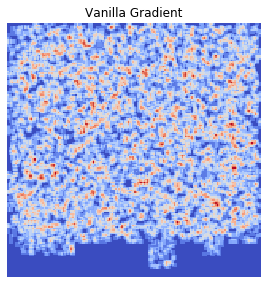

In [109]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     graph = tf.get_default_graph()

image_input = env.reset()
#     print(image_input.shape)
observation_p = state_processor.process(sess, image_input)
observation = np.stack([observation_p] * 4, axis=2)
observations = np.array([observation]*2)

observations_float32 = observations.astype(np.float32) / 255.0
print(observations_float32.shape)

print(observations.shape)
print(target_estimator.predict(sess, observations))


neuron_selector = tf.placeholder(tf.int32)
y_qq = target_estimator.predictions[0][neuron_selector]
print(target_estimator.predictions[0])

prediction_action = tf.argmax(target_estimator.predictions[0])
prediction_class = sess.run(prediction_action, { target_estimator.X: observations})

print("prediction_class: ", prediction_class)
print("y_qq", sess.run(y_qq, feed_dict={neuron_selector: prediction_class, target_estimator.X: observations}))


# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y_qq, target_estimator.X)

gradients = tf.gradients(y_qq, target_estimator.X)
print("gradients:", gradients)
sess.run(gradients, feed_dict={neuron_selector: prediction_class, target_estimator.X: observations})
#     sess.run(gradients, feed_dict={neuron_selector: prediction_class, target_estimator.X_pl: observations})

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(observations, feed_dict = {neuron_selector: prediction_class})
#     smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(observations_float32, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageDiverging(vanilla_mask_3d)
#     smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.

print(vanilla_mask_grayscale.shape)

ShowFilteredImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
#     ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))    




### Guided Backprop

(1, 160, 160, 4)
[[0.08088372 0.         0.00235147 0.        ]]
Tensor("strided_slice_6:0", shape=(4,), dtype=float32)
[None]
gradients: [<tf.Tensor 'gradients_4/target_q/Conv/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 160, 160, 4) dtype=float32>]
INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


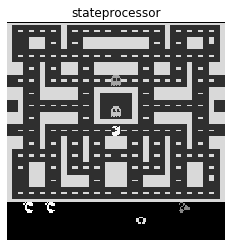

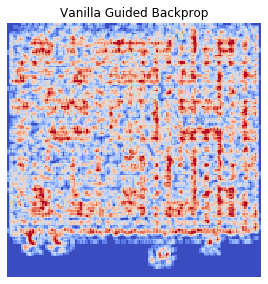

In [108]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     graph = tf.get_default_graph()

image_input = env.reset()
observation_p = state_processor.process(sess, image_input)


ShowGrayscaleImage(observation_p, title="stateprocessor")

stacked_im = np.stack([observation_p] * 4, axis=2)
batched_im = np.array([stacked_im])

batched_im_float32 = batched_im.astype(np.float32) / 255.0

print(batched_im.shape)
print(target_estimator.predict(sess, batched_im))


neuron_selector = tf.placeholder(tf.int32)
y_qq = target_estimator.predictions[0][neuron_selector]
print(target_estimator.predictions[0])

prediction_action = tf.argmax(target_estimator.predictions[0])
prediction_class = sess.run(prediction_action, { target_estimator.X: batched_im})

print(tf.gradients(state_processor.output, state_processor.input_state))


gradients = tf.gradients(y_qq, target_estimator.X)
print("gradients:", gradients)
sess.run(gradients, feed_dict={neuron_selector: prediction_class, target_estimator.X: batched_im})

# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
# NOTE: GuidedBackprop creates a copy of the given graph to override the gradient.
# Don't construct too many of these!
guided_backprop = saliency.GuidedBackprop(graph, sess, y_qq, target_estimator.X)

# Compute the vanilla mask and the smoothed mask.
vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(
    batched_im_float32, feed_dict = {neuron_selector: prediction_class})
#     smoothgrad_guided_backprop_mask_3d = guided_backprop.GetSmoothedMask(
#         batched_im_float32, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageDiverging(vanilla_guided_backprop_mask_3d)
#     smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_guided_backprop_mask_3d)

#     print(smoothgrad_mask_grayscale.shape)
# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowFilteredImage(vanilla_mask_grayscale, title='Vanilla Guided Backprop', ax=P.subplot(ROWS, COLS, 1))
#     ShowDivergingImage(vanilla_mask_grayscale, title='Vanilla Guided Backprop', ax=P.subplot(ROWS, COLS, 1))
#     ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad Guided Backprop', ax=P.subplot(ROWS, COLS, 2))



### Integrated Gradient

(1, 160, 160, 4)
[[0.08088372 0.         0.00235147 0.        ]]
Tensor("strided_slice_14:0", shape=(4,), dtype=float32)
[None]
x_baseline (1, 160, 160, 4)
x_value (1, 160, 160, 4)
(160, 160)
(160, 160)


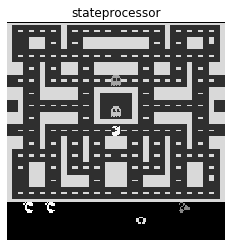

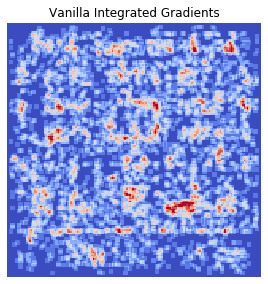

In [110]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     graph = tf.get_default_graph()

image_input = env.reset()
observation_p = state_processor.process(sess, image_input)


ShowGrayscaleImage(observation_p, title="stateprocessor")

stacked_im = np.stack([observation_p] * 4, axis=2)
batched_im = np.array([stacked_im])

batched_im_float32 = batched_im.astype(np.float32) / 255.0

print(batched_im.shape)
print(target_estimator.predict(sess, batched_im))


neuron_selector = tf.placeholder(tf.int32)
y_qq = target_estimator.predictions[0][neuron_selector]
print(target_estimator.predictions[0])

prediction_action = tf.argmax(target_estimator.predictions[0])
prediction_class = sess.run(prediction_action, { target_estimator.X: batched_im})

print(tf.gradients(state_processor.output, state_processor.input_state))


# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = saliency.IntegratedGradients(graph, sess, y_qq, target_estimator.X)
#     integrated_gradients = IntegratedGradients(graph, sess, y_qq, target_estimator.X)


# Baseline is a black image.
baseline = np.zeros(batched_im.shape)
baseline.fill(-1)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  batched_im_float32, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
# smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
#   im, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline)

print(vanilla_integrated_gradients_mask_3d[0,:,:,0].shape)

#     vanilla_integrated_gradients_mask_3d = vanilla_integrated_gradients_mask_3d[0,:, :, 1]
# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
#     smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)
print(vanilla_mask_grayscale.shape)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowFilteredImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
#     ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
# ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

In [ ]:
[print(n.name) for n in tf.get_default_graph().as_graph_def().node]

### XRAI

In [106]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
graph = tf.get_default_graph()

[[0.08088372 0.         0.00235147 0.        ]]
Tensor("strided_slice_2:0", shape=(4,), dtype=float32)
[None]
gradients: [<tf.Tensor 'gradients_1/target_q/Conv/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 160, 160, 4) dtype=float32>]
x_baselines: (1, 160, 160, 4)
x_baseline (1, 160, 160, 4)
x_value (1, 160, 160, 4)
x_baseline (1, 160, 160, 4)
x_value (1, 160, 160, 4)
attrs: 0.041204564
attr: (1, 160, 160, 4)
original (160, 160)
imshape here: (1, 160, 160, 4)
scale_range [-1.0, 1.0]


/home/yucaif/.local/lib/python3.6/site-packages/skimage/segmentation/_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


(1, 160, 160)


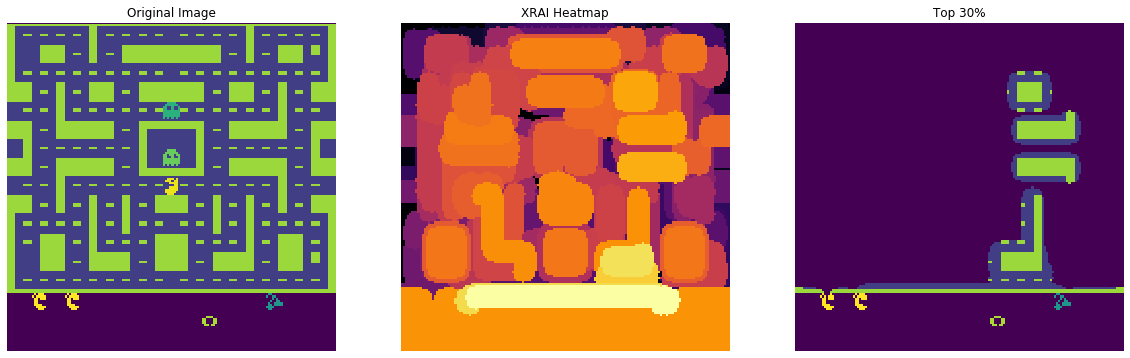

In [107]:
image_input = env.reset()
observation_p = state_processor.process(sess, image_input)
stacked_im = np.stack([observation_p] * 4, axis=2)
batched_im = np.array([stacked_im])
print(target_estimator.predict(sess, batched_im))
batched_im_float32 = batched_im.astype(np.float32) / 255.0

neuron_selector = tf.placeholder(tf.int32)
y_qq = target_estimator.predictions[0][neuron_selector]
print(target_estimator.predictions[0])

prediction_action = tf.argmax(target_estimator.predictions[0])
prediction_class = sess.run(prediction_action, { target_estimator.X: batched_im})

print(tf.gradients(state_processor.output, state_processor.input_state))


# ---------------------- Visualizing -----------------------------
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.

gradients = tf.gradients(y_qq, target_estimator.X)
print("gradients:", gradients)
sess.run(gradients, feed_dict={neuron_selector: prediction_class, target_estimator.X: batched_im})

#     xrai_object = saliency.XRAI(graph, sess, y_qq, target_estimator.X)
xrai_object = saliency.XRAI(graph, sess, y_qq, target_estimator.X)

# Compute the vanilla mask and the smoothed mask.
xrai_attributions = xrai_object.GetMask(
    batched_im_float32, feed_dict = {neuron_selector: prediction_class})

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(observation_p, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
print(xrai_attributions.shape)
xrai_attributions = xrai_attributions[0]
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 70)
im_mask = np.array(batched_im[0,:,:,0])
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))    


